In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [20]:
class LinearSVM:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization,multiclass):
       # self.learning_rate = learning_rate

        size = len(dataset[0])-1
        n = len(dataset)
        w = np.ones(size) #1/size * 
        
        w_norms = []
        
        for i in range(epochs):
            np.random.shuffle(dataset)
            for j in range(len(dataset)):
                #learning_rate = 1/ (j + epochs)
                x = dataset[j,:-1]
                y = dataset[j,-1]
        #        print(x,y)
        
                ywx = mc_hinge(w,x,y) if multiclass else y * w.dot(x) 
                    
                if ywx < 1:
                    gradient = (2 * regularization * w) / n - y*x
                else:
                    gradient = (2 * regularization * w) / n
                
                w = w - learning_rate * gradient
            
            w_norms.append(np.linalg.norm(w))
        
        return w, w_norms
        
    def predict(dataset,w):
        y = np.array(len(dataset)) 
        dataset = dataset[:,:-1]
        
        for i in range(len(dataset)):
            y[i] = np.dot(dataset[i],w)
        return y
    def mc_hinge(w,x,y):
    
        '''
        w_i - vector of weights of the SVM for the class i; w has |features| rows and |classes| columns
        x - features of a sample
        y - label of a sample
        loss = max{0, max(w_j*x - w_y*x)}, j={0,...,|classes|-1}, j!=y
        '''

        n_features, n_class = np.shape(w)
        wyx = w[:,y].dot(x)
        max_dif = - np.inf

        for j in [i for i in range(n_class) if i != y]:
            wjx = w[:,j].dot(x)
            if wjx > max_dif:
                max_dif = wjx

        max_dif -= wyx

        if max_dif > 0:
            return 1 + max_dif
        else:

            return 0

def accuracy(y,y_pred):
    return sum(y == y_pred)/len(y)
    
    
def calculate_exact_w(dataset, regularization):
    # set initial w0
    size = len(dataset[0])-1
    w0 = (1/size) * np.ones(size) #

    # define the constraint
    con = {'type': 'ineq', 'fun': lambda w : 1/regularization - np.linalg.norm(w)}

    # optimize target function using scipy.optimize.minimize
    res = minimize(target_func, x0=w0, args=(dataset), constraints=con, method='SLSQP') #

    return res.x


def target_func(w, data ):
    f = 0
    for i in range(len(data)):
        f += max(0, 1 - data[i][-1] * np.dot(w, data[i][0:-1]))

    return f



In [3]:
#read data
data = pd.read_csv('toydata_tiny.csv').to_numpy()

#add one to each feature vector
#data = np.insert(data, obj = 4, values = np.ones(len(data)), axis = 1)

# shuffle along the first axis of array
#np.random.shuffle(data)

In [4]:
mySVM = linearSVM()
regularization = 0.01
learning_rate = 0.001
epochs = 400
w, w_norms = mySVM.fit(data,learning_rate,epochs,regularization)
print(w)
print(np.linalg.norm(w))

w_exact = calculate_exact_w(data,regularization)
print(w_exact)
print(np.linalg.norm(w_exact))


[ 1.28495909 -2.18040464]
2.5308663040718113
[ 1.36453938 -2.2881198 ]
2.664105842274975


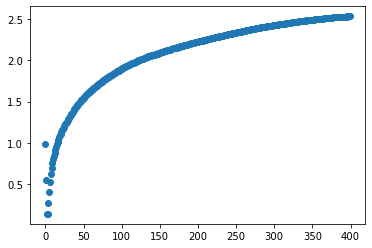

In [5]:
xs = range(epochs)
plt.scatter(xs, w_norms)
#plt.xlim([0,50])
plt.show()

In [6]:
data

array([[ 9.0892326 ,  4.10960065,  1.        ],
       [ 2.84560686,  3.79148159, -1.        ],
       [ 3.86642593,  3.9169604 , -1.        ],
       [ 2.73932464,  2.6105176 , -1.        ],
       [ 2.97064557,  4.24818982, -1.        ],
       [ 7.2129148 ,  4.04143659,  1.        ],
       [ 8.62832353,  4.47012118,  1.        ],
       [ 2.48508838,  3.21384972, -1.        ],
       [ 3.3998028 ,  3.18852943, -1.        ],
       [10.71010319,  3.99124957,  1.        ],
       [ 4.17428476,  4.66334187, -1.        ],
       [ 4.48238902,  4.27489956, -1.        ],
       [10.74352941,  6.17819012,  1.        ],
       [ 2.02624775,  3.63824961, -1.        ],
       [ 8.85406633,  4.04077246,  1.        ],
       [10.20657732,  5.47355707,  1.        ],
       [10.07730113,  5.27873118,  1.        ],
       [ 5.01977546,  2.72404388,  1.        ],
       [ 3.76581576,  4.42308153, -1.        ],
       [ 7.47181116,  2.56588951,  1.        ],
       [ 9.90600599,  4.70667629,  1.   